In [1]:
import numpy as np
import numpy.ma as ma

from astropy.table import Table

from scipy.optimize import minimize, Bounds

from DRP_rotation_curve import extract_data, extract_Pipe3d_data

from disk_mass import calc_mass_curve, fit_mass_curve

from rotation_fitfunctions import find_phi, find_axis_ratio, find_incl, parameterfit_iso, parameterfit_NFW, parameterfit_bur, chi2

from rotation_curve_functions import disk_bulge_vel, halo_vel_NFW, bulge_vel, disk_vel

import RC_plotting_functions as RC#import plot_diagnostic_panel

import matplotlib.pyplot as plt



In [2]:
import sys
sys.path.insert(1,"main/")
from Velocity_Map_Functions_cython import rot_incl_iso, rot_incl_bur, rot_incl_NFW
from galaxy_component_functions_cython import vel_tot_iso, halo_vel_iso, disk_vel, bulge_vel

In [3]:
gal_ID = '11945-1901' 
H_0 = 100  # Hubble's Constant in units of h km/s/Mpc
c = 299792.458  # Speed of light in units of km/s

In [4]:
#MASS_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\pipe3d\v3_1_1\3.1.1\7443"
#VEL_MAP_FOLDER = r"C:\Users\Lara\Documents\rotationcurves\mangadata\analysis\v3_1_1\3.1.0\HYB10-MILESHC-MASTARSSP\7443\12705"
#DRP_FILENAME = r"C:\Users\Lara\Documents\rotationcurves\mangadata\redux\v3_1_1\drpall-v3_1_1.fits"

MANGA_FOLDER = '/scratch/kdougla7/data/SDSS/dr17/manga/spectro/'
MASS_MAP_FOLDER = MANGA_FOLDER + 'pipe3d/'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v3_1_1/3.1.0/HYB10-MILESHC-MASTARSSP/'
DRP_FILENAME = MANGA_FOLDER + 'redux/v3_1_1/' + 'drpall-v3_1_1.fits'

In [5]:
DRP_table = Table.read( DRP_FILENAME, 'MANGA')


DRP_index = {}

for i in range(len(DRP_table)):
    galaxy_ID = DRP_table['plateifu'][i]

    DRP_index[galaxy_ID] = i


In [6]:
# Extract data
maps = extract_data(VEL_MAP_FOLDER,gal_ID,['Ha_vel', 'r_band', 'Ha_flux', 'Ha_sigma'])
sMass_density, sMass_density_err = extract_Pipe3d_data(MASS_MAP_FOLDER, gal_ID)

i_DRP = DRP_index[gal_ID]

In [7]:
# Locate and save photometric parameters
axis_ratio = DRP_table['nsa_elpetro_ba'][i_DRP]
incl = find_incl(axis_ratio)

phi = DRP_table['nsa_elpetro_phi'][i_DRP]
print(axis_ratio)
print(incl)
print(phi)

z = DRP_table['nsa_z'][i_DRP]
print(z)

# Create S/N > 5 mask
SN_map = maps['Ha_flux'] * np.sqrt(maps['Ha_flux_ivar'])
map_mask = maps['Ha_vel_mask'] + (SN_map < 5)

# Mask the velocity map with the S/N > 5 mask
maps['vmasked'] = ma.array(maps['Ha_vel'], mask=map_mask)
maps['ivarmasked'] = ma.array(maps['Ha_vel_ivar'], mask=map_mask)

shape = maps['vmasked'].shape

# Calculate the scale of the pixels
scale = (0.5 * z * c / H_0) * 1000 / 206265  # kpc

center = np.unravel_index(ma.argmax(maps['r_band']), shape)
x_center = center[0]
y_center = center[1]
#center = (15,15)
phi = find_phi(center, phi, maps['vmasked'])

print(phi)

0.87228686
0.5225343935791924
44.950897
0.029205708
0
(16, 16)
0.7845411543748415
3.926133807964635


In [7]:
m = ma.getmask(maps['vmasked'][center])

vsys = maps['vmasked'][center]
print(m)

True


In [12]:
phi = find_phi(center, phi, maps['vmasked'])
print(phi)

None


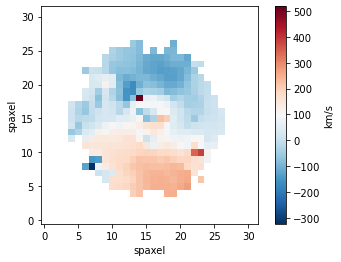

In [8]:
plt.imshow(maps["vmasked"], 
           origin='lower', 
           cmap='RdBu_r')

plt.xlabel('spaxel')
plt.ylabel('spaxel')

cbar = plt.colorbar()
cbar.set_label('km/s')